# Video inference position and distance estimation

Using the od of our model on a new image and a simple projective model

In [1]:
from video_utils import *
from utils.model_tools import *
from utils.processing_tools import *

import infer

## 1. Select a model for inference using the CenterNet object detector model 

In [2]:
import tensorflow as tf
import larq as lq

We will use the arguments from the inference file as defined in the project readme

In [3]:
args =  ['--architecture', 'resnet50_centernet', '--gpu', '6', '--dataset-path', '../../datasets/PascalVOC/', '--model-weights-path', 'saved_models/resnet50_centernet/resnet50_centernet_model.h5']
# on the inference script we use: args = sys.argv[1:]
args = infer.parse_args(args)

{'architecture': 'resnet50_centernet', 'batch_size': 32, 'num_classes': 20, 'input_size': 512, 'gpu': '6', 'model_summary': True, 'dataset_path': '../../datasets/PascalVOC/', 'model_weights_path': 'saved_models/resnet50_centernet/resnet50_centernet_model.h5'}


Now we get the parsed args

In [4]:
num_classes = args.num_classes
input_size = (args.input_size,args.input_size)
#assert input_size[0] == input_size[1], "Input shape must be the same"
batch_size = args.batch_size
# optionally choose specific GPU
if args.gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
# CHECK GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print('problem loading gpu')
import importlib
sys.path.append('architectures')
#import architecture module
architecture_module = importlib.import_module(args.architecture)

# set architecture name
architecture_name = args.architecture

Default GPU Device: /device:GPU:0


Instantiate a model, download weights and compile

In [5]:
# create model given an architecture
# (the centernet input must be specified by the architecture file)
model, prediction_model, debug_model = architecture_module.centernet(input_size = input_size, num_classes = num_classes)

try:
    model.load_weights(args.model_weights_path)
    print("Model loaded!")
except:
    print("Error: Failed loading model from weights...")
    #sys.exit(1)

# compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss={'centernet_loss': lambda y_true, y_pred: y_pred})

# change to True to print model summary
if False:
    lq.models.summary(model)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model loaded!


Open the validation dataset and instantiate a generator

## 2. Video data 

Here we ontain the data for the video streams

### 2.1. Get the .mp4 files relative to the intersection

Note that this depends on the data location. 

In [6]:
# Input path do folder containing mp4 samples
folder_path = os.path.join('..','..','datasets','NokiaVillarceauxVideoFeed','INTERSECTION')
print('Folder location: {}'.format(folder_path, {}))

Folder location: ../../datasets/NokiaVillarceauxVideoFeed/INTERSECTION


In [7]:
list_mp4_files, list_mp4_names = get_mp4_filepaths(folder_path, verbose = 0)

Found 2 .mp4 files: 

file idx:  0
file name: BOU-VIRT(A)-NORD-OUEST_2022-07-12_14h05min00s00ms.mp4

file idx:  1
file name: BOU-EXT-NORD-OUEST_2022-07-12_14h10min49s287ms.mp4



Now loop on the video files and check their integrity

Selected file name:  BOU-VIRT(A)-NORD-OUEST_2022-07-12_14h05min00s00ms.mp4
Video width: 1920, video height = 1080
Video length in frames: 6752.0, video fps rate = 30.0 [s^-1], play time = 225.06666666666666 [ms]
Video duration [h:mm:ss] : 0:03:45.066667
First frame: 


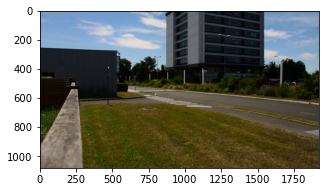

Success checking integrity...


Selected file name:  BOU-EXT-NORD-OUEST_2022-07-12_14h10min49s287ms.mp4
Video width: 1920, video height = 1080
Video length in frames: 17857.0, video fps rate = 14.990312582897092 [s^-1], play time = 1191.236 [ms]
Video duration [h:mm:ss] : 0:19:51.236000
First frame: 


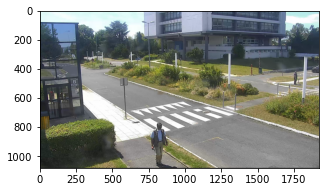

Success checking integrity...




In [8]:
check_mp4_list(list_mp4_files, list_mp4_names, display_frame = True )

### 2.2 Check both footages at the same time (not synchronized)

In [9]:
# get time in seconds from [h:mm:ss] format
sample_time = '0:01:15.001'
time_seconds = string2seconds(sample_time)
print('Desired time in seconds: {} [s]'.format(time_seconds))

Desired time in seconds: 75.001 [s]


For the first video we obtain the following images:

In [10]:
# display the frame relative to the timestamp
img_a = get_frame_time(list_mp4_files[0], time_of_interest = time_seconds, plot_img = False, verbose = 0)
img_b = get_frame_time(list_mp4_files[1], time_of_interest = time_seconds, plot_img = False, verbose = 0)

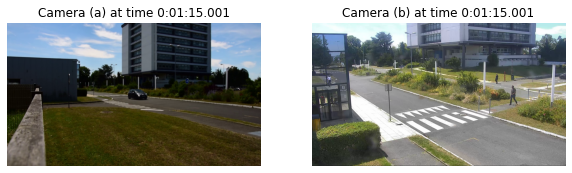

In [11]:
# create figure
fig = plt.figure(figsize=(10, 10))
# Adds a subplot at the 1st position
fig.add_subplot(1, 2, 1)
# showing image
plt.imshow(img_a)
plt.axis('off')
plt.title("Camera (a) at time {}".format(sample_time))
# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)
# showing image
plt.imshow(img_b)
plt.axis('off')
plt.title("Camera (b) at time {}".format(sample_time))
fig.show()

We observe that the cameras are unsynchronysed.

### 2.3 Video synchronisation

We synchronyse the video by carefully observing world events to obtain approximately the same timestamp. 

In the case of the car with the blue hood we chose the approximate second that it hits the road bump.

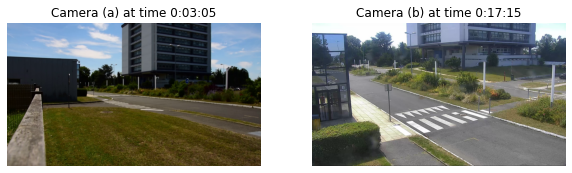

In [13]:
# road bump timestamp
roadbump_time_a = '0:03:10'
roadbump_time_b = '0:17:20'

# 5 seconds before roadbump
init_time_diff = 5

# get time in seconds from [h:mm:ss] format
time_seconds_a = string2seconds(roadbump_time_a) - init_time_diff
time_seconds_b = string2seconds(roadbump_time_b) - init_time_diff


# display the frame relative to the timestamp
img_a = get_frame_time(list_mp4_files[0], time_of_interest = time_seconds_a, plot_img = False, verbose = 0)
img_b = get_frame_time(list_mp4_files[1], time_of_interest = time_seconds_b, plot_img = False, verbose = 0)

# create figure
fig = plt.figure(figsize=(10, 10))
# Adds a subplot at the 1st position
fig.add_subplot(1, 2, 1)
# showing image
plt.imshow(img_a)
plt.axis('off')
plt.title("Camera (a) at time {}".format(str(datetime.timedelta(seconds=time_seconds_a))))
# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)
# showing image
plt.imshow(img_b)
plt.axis('off')
plt.title("Camera (b) at time {}".format(str(datetime.timedelta(seconds=time_seconds_b))))
fig.show()

## 3. Object detection on video 

With the timestamped videos we can do object detection on both images.

In [14]:
# save colours
colors = [[16, 126, 66], [21, 19, 217], [57, 230, 240], [198, 240, 55], [5, 106, 218], [80, 30, 189], 
          [94, 251, 125], [236, 23, 71], [223, 224, 40], [231, 40, 49], [133, 150, 237], [254, 142, 70],
           [255, 50, 255], [192, 212, 92], [8, 180, 64], [185, 177, 24], [110, 187, 253], [223, 47, 237],
           [109, 178, 31], [101, 51, 125]]

In [20]:
# select fps rate of analysis
out_fps = 16
delta_t = 1/out_fps

# video output length
video_length = '0:00:10.0'
video_length_seconds = string2seconds(video_length)

# select number of frames
max_it = out_fps*video_length_seconds

In [21]:
# Use the prediction model with loaded weights
predictions_a, images_a = video_od(prediction_model, list_mp4_files[0], 
                                   initial_time = time_seconds_a, delta_t = delta_t, max_it = max_it, 
                                   return_images = True, plot_img = False, 
                                   figsize = (15,15),  colors = colors, verbose = 0)

In [22]:
# Use the prediction model with loaded weights
predictions_b, images_b = video_od(prediction_model, list_mp4_files[1],
                                   initial_time = time_seconds_b, delta_t = delta_t, max_it = max_it, 
                                   return_images = True, plot_img = False, 
                                   figsize = (15,15),  colors = colors, verbose = 0)

### 3.2 Plot images side by side

We visual check that the model is finding the car in both detections

In [23]:
# Filter predictions (set verbose to 1 to display additional info)
pred_filtered_a = []
pred_filtered_b = []
for pred_a, pred_b in zip(predictions_a, predictions_b):
    pred_filtered_a.append(analyse_prediction(pred_a, verbose = 0, conf_thresh = 0.2, img_dimensions = (1920,1080), display_classes = [6,14]))
    pred_filtered_b.append(analyse_prediction(pred_b, verbose = 0, conf_thresh = 0.2, img_dimensions = (1920,1080), display_classes = [6,14]))

No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected
No objects detected


In [24]:
# Display images side by side
if False:
    for image_a, pred_a, image_b, pred_b in zip(images_a, pred_filtered_a, images_b, pred_filtered_b):
        image_a = add_bbox(image_a, pred_a, colors = colors)
        image_b = add_bbox(image_b, pred_b, colors = colors)

        result_img = np.concatenate((image_a, image_b), axis=1)
        plt.figure(figsize = (10,10))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

In [25]:
# Output a video with images side by side
out_name = 'intersection_test'
out_dim = (1024, 576)
video_fps = 16
# create directory if it doesn't exist
if not os.path.isdir('output'):
    os.mkdir('output')
    
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter(os.path.join('output', out_name + '.mp4'), fourcc, video_fps, out_dim)

for image_a, pred_a, image_b, pred_b in zip(images_a, pred_filtered_a, images_b, pred_filtered_b):
        image_a = add_bbox(image_a, pred_a, colors = colors)
        image_b = add_bbox(image_b, pred_b, colors = colors)

        result_img = np.concatenate((image_b, image_a), axis=1)
        
        # write the OD frame
        out.write(cv2.resize(result_img, out_dim, interpolation = cv2.INTER_AREA))

out.release()

## 3. Position estimation based on Camera Model and Object Detection

# Cam params

**Lens** 4.44-142.6 mm, F1.6-4.41

**Horizontal angle of view:** 62.8˚- 2.23˚

**Vertical angle of view:** 36.8˚- 1.3˚

**Camera world position:** Needs validation but for now we set it as (0,0)

**Camera tilt and camera altitude:** Should be determined experimentally either by callibration or preferably by measures on the ground

## 3.1 Results


#### Validating results: projecting points on image


In [ ]:
# person example ground truth
person_gt = [-5, -5.209267685839688, 32.89002174181808]

# polar to cartesian: (r,/_alpha) in degrees to (x,y) in cartesian
CAM_CENTER_REF_GT_ANGLE = 229 # In degrees
_cart = lambda _r, _alpha : (np.cos(math.radians(_alpha - CAM_CENTER_REF_GT_ANGLE))*_r, np.sin(math.radians(_alpha - CAM_CENTER_REF_GT_ANGLE))*_r)

_pixel_pos = get_bb_center(ppl_predictions[0])
estimation = get_object_pos(_pixel_pos)

print('pixel coordinates = {}'.format(_pixel_pos))
print('ground truth = ({}, {}) [m]'.format(person_gt[2], person_gt[1]))
print('estimation = {} [m]'.format(estimation))

In [ ]:
# car ground truth
car_gt = [-5, -1.88, 35.95]


_pixel_pos = get_bb_center(car_predictions[0])
estimation = get_object_pos(_pixel_pos)

print('pixel coordinates = {}'.format(_pixel_pos))
print('ground truth = ({}, {})'.format(car_gt[2], car_gt[1]))
print('estimation = {}'.format(estimation))

#### Using ground truth points

Obs.: Note that the ground truth points assume the same height with respect to the camera, a condition that may not be true

In [ ]:
coords_estimation = [get_object_pos([px_coords[1],px_coords[0]], camera_tilt = W) for px_coords in gt_pixel_coords]
for idx, (pixel, gt) in enumerate(zip(gt_pixel_coords, gt_cartesian_measures)):
    print('TEST {}:'.format(idx))
    print('pixel coordinates = {} '.format(pixel))
    print('ground truth = ({}, {}) [m]'.format(gt[2], gt[1]))
    print('estimation = {} [m]'.format(coords_estimation[idx]))
    print('#########################')

## 4. Speed estimation Proof of concept

#### Frame extraction spaced by delta_t





In [ ]:
delta_t = 1/14*5 # skip approx 5 frames
t0 = 0.00

In [ ]:
test_img_1 = get_frame_time(filepath, time_of_interest = t0, plot_img = True, verbose = 1)

In [ ]:
test_img_2 = get_frame_time(filepath, time_of_interest = t0+delta_t, plot_img = True, verbose = 1)

In [ ]:
test_img_3 = get_frame_time(filepath, time_of_interest = t0+2*delta_t, plot_img = True, verbose = 1)

In [ ]:
# OD on different 2 frames blocks
def speed_inference(images, delta_t, pred_model, classes = voc_classes,  
             plot_img = False , figsize = (15,15), colors = None, verbose = 0):
    """
    print or save video frames as images using cv2.
    :images: list of images
    :delta_t:
    :pred_model: object detection model
    :path_in: video file path
    :classes: dict of classes used by the model to predict
    :max_it: describe about parameter p3
    :plot_img: set to True to plot image with matplotlib
    :speed: set speed for reading frames (eg.: speed = 10 reads an image for each 10 frames)
    :pathOut: describe about parameter p2
    :figsize: set figsize for matplotlib imshow
    :colors: set colors according to classes
    :verbose: disable to silence function prints
    :return: list of predictions for each frame
    """ 
        
    if colors is None:
        colors = [np.random.randint(0, 256, 3).tolist() for i in range(len(classes))]
    
    predictions = []
    
    for img in images:  
        predictions.append(image_direct_inference(img, pred_model, colors, verbose = verbose, plot_img = plot_img, figsize = figsize))
    
    
        
    return predictions

In [ ]:
predictions = speed_inference([test_img_1, test_img_2, test_img_3], delta_t, prediction_model)

### Let's predict a single car speed. We have to extract it from the object detection predictions

Obs: We isolate a single car by trimming positions according to the image position

In [ ]:
pred_filtered_1 = analyse_prediction(predictions[0], verbose = 2, img_dimensions = (1920,1080), 
                                   display_classes = [6], ul_lim = (445,0), lr_lim = None)
center_pixel_pos_1 = get_bb_center(pred_filtered_1[0])


In [ ]:
plot_object_center(test_img_1,pred_filtered_1[0])

In [ ]:
pred_filtered_2 = analyse_prediction(predictions[1], verbose = 2, img_dimensions = (1920,1080), 
                                   display_classes = [6], ul_lim = (445,0), lr_lim = None)
center_pixel_pos_2 = get_bb_center(pred_filtered_2[0])

In [ ]:
plot_object_center(test_img_2,pred_filtered_2[0])

In [ ]:
pred_filtered_3 = analyse_prediction(predictions[2], verbose = 2, img_dimensions = (1920,1080), 
                                   display_classes = [6], ul_lim = (445,0), lr_lim = None)
center_pixel_pos_3 = get_bb_center(pred_filtered_3[0])

In [ ]:
plot_object_center(test_img_3,pred_filtered_3[0])

### Now obtain the car position using the position inference

In [ ]:
def speed_estimation(center_px_1, center_px_2, delta_t):
    estimation_1 = get_object_pos(center_px_1)
    estimation_2 = get_object_pos(center_px_2)
    
    delta_z = (estimation_2[0] - estimation_1[0])
    delta_y = (estimation_2[1] - estimation_1[1])
    
    speed_zy = [delta_z/delta_t, delta_y/delta_t]
    
    return np.linalg.norm(speed_zy, ord = 2), speed_zy

#####  Between frame 1 and 2

In [ ]:
vector_speed = speed_estimation(center_pixel_pos_1, center_pixel_pos_2, delta_t)
print("Absolute inferred speed is {:.2f} [Km/h]".format(vector_speed[0]*3.6))
print("inferred speed direction is ({:.2f},{:.2f}) [Km/h]".format(vector_speed[1][0]*3.6, vector_speed[1][1]*3.6))

#####  Between frame 2 and 3

In [ ]:
vector_speed = speed_estimation(center_pixel_pos_2, center_pixel_pos_3, delta_t)
print("Absolute inferred speed is {:.2f} [Km/h]".format(vector_speed[0]*3.6))
print("inferred speed direction is ({:.2f},{:.2f}) [Km/h]".format(vector_speed[1][0]*3.6, vector_speed[1][1]*3.6))

#####  Between frame 1 and 3

In [ ]:
vector_speed = speed_estimation(center_pixel_pos_1, center_pixel_pos_3, 2*delta_t)
print("Absolute inferred speed is {:.2f} [Km/h]".format(vector_speed[0]*3.6))
print("inferred speed direction is ({:.2f},{:.2f}) [Km/h]".format(vector_speed[1][0]*3.6, vector_speed[1][1]*3.6))

## 5. Plot Speed Inference given the last prediction

Note the best approximation would be to use a Kalman filter, but we leave this as a next implementation.

In [ ]:
def video_od(pred_model, path_in, classes = voc_classes, max_it = 5, delta_t = 1, 
             plot_img = False , figsize = (15,15), colors = None, verbose = 0):
    """
    print or save video frames as images using cv2 doing object detection.
    :pred_model: object detection model
    :path_in: video file path
    :classes: dict of classes used by the model to predict
    :max_it: maximum number of iterations
    :plot_img: set to True to plot image with matplotlib
    :delta_t: time diference between frames [seconds]
    :pathOut: pathout for video
    :figsize: set figsize for matplotlib imshow
    :colors: set colors according to classes
    :verbose: disable to silence function prints
    :return: list of predictions for each frame
    """ 
    
    
    if colors is None:
        colors = [np.random.randint(0, 256, 3).tolist() for i in range(len(classes))]
    
    predictions = []
    
    count = 0
    
    # open video with cv2
    vidcap = cv2.VideoCapture(path_in)
    
    # Convert the resolutions from float to integer.
    frame_width = int(vidcap.get(3))
    frame_height = int(vidcap.get(4))
    
    # Get number of frames
    nframes = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get fps rate
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    if verbose > 0:
        print ('Video width: {}, video height = {}'.format(frame_width, frame_height))
        print ('Video length in frames: {}, video fps rate = {} [s^-1], play time = {} [ms]'.format(nframes, fps, nframes/fps))

    
    success,image = vidcap.read()
    success = True
    while success:
        time = count*delta_t
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(time*1000))    # added this line 
        success,image = vidcap.read()
        
        if verbose > 0:
            # calculate frame of the timestamp
            frame_of_interest = int(time*fps)
            print ('Frame Found: frame = {} , time captured = {:.2f} [s]'.format(frame_of_interest, time))

        src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pred = image_direct_inference(image, pred_model, colors, verbose = verbose, plot_img = plot_img, figsize = figsize)
        predictions.append(pred)
        
        count = count + 1
        if count >= max_it:
            break
        
    return predictions


In [ ]:
# OD on different frames blocks
def video_speed_pos_inference(pred_model, path_in, classes = voc_classes, max_it = 5, speed = 1, 
             plot_img = False , figsize = (15,15), colors = None, verbose = 0):
    """
    print or save video frames as images using cv2.
    :pred_model: object detection model
    :path_in: video file path
    :classes: dict of classes used by the model to predict
    :max_it: describe about parameter p3
    :plot_img: set to True to plot image with matplotlib
    :speed: set speed for reading frames (eg.: speed = 10 reads an image for each 10 frames)
    :pathOut: describe about parameter p2
    :figsize: set figsize for matplotlib imshow
    :colors: set colors according to classes
    :verbose: disable to silence function prints
    :return: list of predictions for each frame
    """ 
    
    
    if colors is None:
        colors = [np.random.randint(0, 256, 3).tolist() for i in range(len(classes))]
    
    predictions = []
    positions = [] 
    times = []
    speeds = []
    
    
    count = 0
    vidcap = cv2.VideoCapture(path_in)
    
    if verbose > 0:
         # Convert the resolutions from float to integer.
        frame_width = int(vidcap.get(3))
        frame_height = int(vidcap.get(4))
        print ('Video width: {}, video heigth = {}'.format(frame_width, frame_height))
    
    success,image = vidcap.read()
    success = True
    
    while success:
            
        time = count*speed
        times.append(time)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(time))    # added this line 
        success,image = vidcap.read()
        if verbose > 0:
            print ('Read a new frame: {}, time = {} [ms] , iteration = {}'.format(success, time, count))
        
        src_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pred = image_direct_inference(image, pred_model, colors, verbose = verbose, plot_img = False, figsize = figsize)
        
        
        # filter preds
        filt_pred = analyse_prediction(pred, verbose = 0, img_dimensions = (1920,1080), 
                                   display_classes = [6], ul_lim = (445,0), lr_lim = None)
        predictions.append(filt_pred)
        
        # hopefully only only one car is present
        center_pixel_pos = get_bb_center(filt_pred[0])
        
        # obtain position of center in world coordinates
        world_pos_estimation = get_object_pos(center_pixel_pos)
        positions.append(world_pos_estimation)
        
        # calculate speed wrp to previous frame
        if count > 0:
            delta_t = times[count] - times[count-1]
            delta_z = (positions[count][0] - positions[count-1][0])
            delta_y = (positions[count][1] - positions[count-1][1])
            speed_zy = [delta_z/delta_t*1000*3.6, delta_y/delta_t*1000*3.6]
            speeds.append([np.linalg.norm(speed_zy,ord = 2), speed_zy])
        else:
            speeds.append([0,[0,0]])

        # should have made at least one pred
        
        count = count + 1
        if count >= max_it:
            break
        
    return predictions, positions, speeds

In [ ]:
preds_car, positions_car, speeds_car = video_speed_pos_inference(prediction_model, filepath, max_it = 5, plot_img = True, figsize = (15,15), speed = 500, verbose = 1)

In [ ]:
preds_car

In [ ]:
positions_car

In [ ]:
speeds_car